# CASA0007 Major Assignment

## 1. Overview

### 1.1 Research question
How are levels of unment HIV pre-exposure prophylaxis (PrEP) need associated with regional characteristics in England?

### 1.2 Data Sources
1. UK Health Security Agency PrEP Tables, from the [National PrEP monitoring and evaluation framework](https://www.gov.uk/government/publications/hiv-pre-exposure-prophylaxis-prep-monitoring-and-evaluation)  
    - HIV PrEP Need  
    - HIV prevalence  
    - HIV new diagnosis rates  
2. ONS Census [Geographical Correspondence](https://www.ons.gov.uk/methodology/geography/ukgeographies/administrativegeography/england)
3. ONS Census Demographic Data, from [Nomis](https://www.nomisweb.co.uk/sources/census_2011_ks)  
    - Country of birth
    - Ethnicity
    - Religion
    - Population density
    - Living arrangements
    - Marriages/Civil partnerships
    - Sexuality & Gender Identity
    - Socioeconomic status
    - Years lived in the UK
4. Rural/Urban Population by Local Authority, from [Department for Environment, Food and Rural Affairs](https://www.gov.uk/government/statistics/2011-rural-urban-classification-of-local-authority-and-other-higher-level-geographies-for-statistical-purposes)

**Data still need to source:**
- Sexual health service funding by county
- Social attitudes by county (e.g. indicators of openness to LGBT community)


In [1]:
#Reading in libaries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels
import statsmodels.formula.api as smf
from statsmodels.formula.api import ols
from statsmodels.tools.tools import maybe_unwrap_results
from statsmodels.graphics.gofplots import ProbPlot
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from typing import Type

from functools import reduce

In [2]:
!pip install skimpy
from skimpy import clean_columns

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 237.5/237.5 kB 1.9 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.0/121.0 kB 3.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.1/51.1 kB 3.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.6/83.6 kB 1.6 MB/s eta 0:00:00a 0:00:01


## 2. Data Preparation

### 2.1 Load data

**Geographic Correspondence File** *CAN DELETE??*

In [3]:
# Read in correspondence data
correspondence = pd.read_csv('data/pcd_oa_lsoa_msoa_ltla_utla_rgn_ctry_ew_may_2021_lu_v2.csv',
                            dtype='str')

# correspondence.dtypes

In [4]:
# correspondence.head(5)

**Urban Rural Classification**

In [5]:
ruralurban = clean_columns(pd.read_csv('data/rural_urban_county_classification.csv'))

# Select desired columns
ruralurban = ruralurban[["upper_tier_local_authority_area_2021_code", "rural_urban_classification_2011_6_fold", "rural_urban_classification_2011_3_fold"]]

# Rename columns
ruralurban.rename(columns = {"upper_tier_local_authority_area_2021_code":"mnemonic",
                             "rural_urban_classification_2011_6_fold":"ru_6fold",
                             "rural_urban_classification_2011_3_fold":"ru_3fold"},
                 inplace = True)

# Create 2-fold combined column
ruralurban["ru_2fold"] = np.where(ruralurban.ru_3fold == "Predominantly Rural", "Regional-Rural",
                                  np.where(ruralurban.ru_3fold == "Urban with Significant Rural", "Regional-Rural",
                                           np.where(ruralurban.ru_3fold == "Predominantly Urban", "Urban", "")))

# Create a London vs Other column
ruralurban["ru_londonother"] = np.where(ruralurban.mnemonic.str.contains("E09"), "London", "Outside London")
ruralurban

4 column names have been cleaned

,mnemonic,ru_6fold,ru_3fold,ru_2fold,ru_londonother
0,E06000011,Largely Rural,Predominantly Rural,Regional-Rural,Outside London
1,E06000019,Largely Rural,Predominantly Rural,Regional-Rural,Outside London
2,E06000047,Largely Rural,Predominantly Rural,Regional-Rural,Outside London
3,E06000051,Largely Rural,Predominantly Rural,Regional-Rural,Outside London
4,E06000054,Largely Rural,Predominantly Rural,Regional-Rural,Outside London
...,...,...,...,...,...
147,E10000018,Urban with Significant Rural,Urban with Significant Rural,Regional-Rural,Outside London
148,E10000024,Urban with Significant Rural,Urban with Significant Rural,Regional-Rural,Outside London
149,E10000028,Urban with Significant Rural,Urban with Significant Rural,Regional-Rural,Outside London
150,E10000031,Urban with Significant Rural,Urban with Significant Rural,Regional-Rural,Outside London


**HIV/PrEP Data**

In [6]:
# Read in outcome (HIV and PrEP) data
hivprepneed = clean_columns(pd.read_csv('data/STI by county/hiv-prep-need.csv'))

# Check field types read in as expected
# hivprepneed.dtypes

# Remove first row (contains England total)
hivprepneed.drop(index = 0, inplace = True)

# Select desired columns
hivprepneed = hivprepneed[['area_code', 'value', 'count', 'denominator']]

# Rename columns
hivprepneed.rename(columns = {"value":"prepneed_value",
                              "count":"prepneed_count",
                              "denominator":"prepneed_denominator",
                             "area_code":"mnemonic"},
                  inplace = True)

hivprepneed.head()

27 column names have been cleaned

,mnemonic,prepneed_value,prepneed_count,prepneed_denominator
1,E09000001,32.0755,187,583
2,E09000033,27.2595,"2,805",10290
3,E09000011,26.9429,943,3500
4,E09000007,22.5322,"1,922",8530
5,E09000030,22.1485,"3,670",16570


In [7]:
# Read in HIV new diagnosis data
hivnewdiagnosis = clean_columns(pd.read_csv('data/STI by county/new-hiv-diagnosis.csv'))

# Check field types read in as expected
# hivnewdiagnosis.dtypes

# Remove first row (contains England total)
hivnewdiagnosis.drop(index = 0, inplace = True)

# Select desired columns
hivnewdiagnosis = hivnewdiagnosis[['area_code', 'value', 'count', 'denominator']]

# Rename columns
hivnewdiagnosis.rename(columns = {"value":"hivnewdiag_value",
                              "count":"hivnewdiag_count",
                              "denominator":"hivnewdiag_denominator",
                             "area_code":"mnemonic"},
                  inplace = True)

hivnewdiagnosis.head()

27 column names have been cleaned

,mnemonic,hivnewdiag_value,hivnewdiag_count,hivnewdiag_denominator
1,E09000028,22.1863,71,320017
2,E09000022,18.6444,60,321813
3,E09000033,18.5289,50,269848
4,E06000039,17.3824,26,149577
5,E09000014,15.7683,42,266357


In [8]:
# Read in HIV PrEP use data
hivprepuse = clean_columns(pd.read_csv('data/STI by county/hiv-prep-use-by-need.csv'))

# Check field types read in as expected
# hivprepuse.dtypes

# Remove first row (contains England total)
hivprepuse.drop(index = 0, inplace = True)

# Select desired columns
hivprepuse = hivprepuse[['area_code', 'value', 'count', 'denominator']]

# Rename columns
hivprepuse.rename(columns = {"value":"prepuse_value",
                              "count":"prepuse_count",
                              "denominator":"prepuse_denominator",
                             "area_code":"mnemonic"},
                  inplace = True)

hivprepuse.head()

27 column names have been cleaned

,mnemonic,prepuse_value,prepuse_count,prepuse_denominator
1,E09000001,86.6310,162,187
2,E09000019,84.2957,"1,927",2286
3,E09000030,84.0599,"3,085",3670
4,E09000022,83.7037,"3,842",4590
5,E09000011,83.5631,788,943


In [9]:
# Read in HIV prevalence data
hivprevalence = clean_columns(pd.read_csv('data/STI by county/hiv-prevalence.csv'))

# Check field types read in as expected
# hivprevalence.dtypes

# Remove first row (contains England total)
hivprevalence.drop(index = 0, inplace = True)

# Select desired columns
hivprevalence = hivprevalence[['area_code', 'value', 'count', 'denominator']]

# Rename columns
hivprevalence.rename(columns = {"value":"hivprev_value",
                              "count":"hivprev_count",
                              "denominator":"hivprev_denominator",
                             "area_code":"mnemonic"},
                  inplace = True)

hivprevalence.head()

27 column names have been cleaned

,mnemonic,hivprev_value,hivprev_count,hivprev_denominator
1,E09000022,12.6706,"2,896",228561.0
2,E09000028,11.2347,"2,490",221634.0
3,E09000001,9.7554,69,7073.0
4,E09000020,8.7937,863,98139.0
5,E09000033,8.4740,"1,534",181025.0


**Census Demographic Data**

In [10]:
# # Read in predictor data (Census demographics)
# cob = clean_columns(pd.read_csv('data/Census by county/census-2021-clean/cob-detailed.csv'))

# ethnicity = clean_columns(pd.read_csv('data/Census by county/census-2021-clean/ethnicity.csv'))

# genderidentity = clean_columns(pd.read_csv('data/Census by county/census-2021-clean/gender-identity.csv'))

# highested = clean_columns(pd.read_csv('data/Census by county/census-2021-clean/highest-qualification.csv'))

# # hhdep = clean_columns(pd.read_csv('data/Census by county/census-2021-clean/household-deprivation.csv'))

# partners = clean_columns(pd.read_csv('data/Census by county/census-2021-clean/legal-partnership.csv'))

# sexuality = clean_columns(pd.read_csv('data/Census by county/census-2021-clean/sexuality.csv'))

# religion = clean_columns(pd.read_csv('data/Census by county/census-2021-clean/religion.csv'))

# # nssec = clean_columns(pd.read_csv('data/Census by county/census-2021-clean/ns-sec.csv'))

# popdens = clean_columns(pd.read_csv('data/Census by county/census-2021-clean/popuation-density.csv'))

# # lengthinuk = clean_columns(pd.read_csv('data/Census by county/census-2021-clean/length-of-residence.csv'))

In [11]:
# (i) COUNTRY OF BIRTH

cob = clean_columns(pd.read_csv('data/Census by county/census-2021-clean/cob-detailed.csv', 
                                nrows = 152)  # read only the 152 English LAs; leave out footer text
                   )

# Clean columns
# cob.dtypes

cob["cob_non_uk_pc"] = 100 - cob["%"]
cob["cob_africa_all"] = cob.africa_north_africa + cob.africa_central_and_western_africa + cob.africa_south_and_eastern_africa + cob.africa_africa_not_otherwise_specified
cob["cob_africa_all_pc"] = cob["%_2"] + cob["%_3"] + cob["%_4"] + cob["%_5"]

cob.rename(columns = {"%":"cob_uk_pc"}, inplace = True)

# Select desired columns
cob = cob[["mnemonic", "cob_uk_pc", "cob_non_uk_pc", "cob_africa_all_pc"]]

cob

34 column names have been cleaned

,mnemonic,cob_uk_pc,cob_non_uk_pc,cob_africa_all_pc
0,E06000005,92.2,7.8,0.7
1,E06000047,95.6,4.4,0.5
2,E06000001,96.0,4.0,0.5
3,E06000002,87.7,12.3,2.3
4,E06000057,96.5,3.5,0.4
...,...,...,...,...
147,E06000054,90.1,9.9,1.4
148,E10000008,92.9,7.1,0.9
149,E06000059,93.5,6.5,1.0
150,E10000013,90.0,10.0,1.4


In [12]:
# (ii) ETHNICITY 
ethnicity = clean_columns(pd.read_csv('data/Census by county/census-2021-clean/ethnicity.csv', 
                                nrows = 152)  # read only the 152 English LAs; leave out footer text
                   )

# Clean columns
ethnicity.dtypes

ethnicity["non_white"] = ethnicity.total_all_usual_residents - ethnicity.white
ethnicity["white_pc"] = round(ethnicity.white/ethnicity.total_all_usual_residents*100, 2)
ethnicity["non_white_pc"] = round(ethnicity.non_white/ethnicity.total_all_usual_residents*100, 2)
ethnicity["black_british_pc"] = round(
    (ethnicity.black_black_british_black_welsh_of_african_background + ethnicity.black_black_british_black_welsh_or_caribbean_background)/
    ethnicity.total_all_usual_residents*100, 2
  )

# Select desired columns
ethnicity = ethnicity[["mnemonic", "white_pc", "non_white_pc", "black_british_pc"]]

ethnicity


8 column names have been cleaned

,mnemonic,white_pc,non_white_pc,black_british_pc
0,E06000005,94.37,5.63,0.65
1,E06000047,96.82,3.18,0.33
2,E06000001,96.46,3.54,0.48
3,E06000002,82.37,17.63,2.65
4,E06000057,97.65,2.35,0.19
...,...,...,...,...
147,E06000054,94.33,5.67,1.13
148,E10000008,96.40,3.60,0.30
149,E06000059,97.06,2.94,0.28
150,E10000013,93.06,6.94,1.20


In [13]:
# (iii) GENDER IDENTITY
genderidentity = clean_columns(pd.read_csv('data/Census by county/census-2021-clean/gender-identity.csv', 
                                nrows = 152)  # read only the 152 English LAs; leave out footer text
                   )

# Clean columns
# genderidentity.dtypes

genderidentity["non_cis_pc"] = round((genderidentity.gender_identity_different_from_sex_registered_at_birth_but_no_specific_identity_given +
                                     genderidentity.trans_woman +
                                     genderidentity.trans_man +
                                     genderidentity.all_other_gender_identities) /
                                     genderidentity.total_all_usual_residents_aged_16_years_and_over*100,
                                     2
                                    )
genderidentity["cis_pc"] = round(genderidentity.gender_identity_the_same_as_sex_registered_at_birth /
                                 genderidentity.total_all_usual_residents_aged_16_years_and_over*100,
                                 2
                                )

# Select desired columns
genderidentity = genderidentity[["mnemonic", "cis_pc", "non_cis_pc"]]

genderidentity

8 column names have been cleaned

,mnemonic,cis_pc,non_cis_pc
0,E06000005,95.09,0.42
1,E06000047,95.07,0.37
2,E06000001,94.51,0.43
3,E06000002,93.04,0.82
4,E06000057,95.48,0.27
...,...,...,...
147,E06000054,94.73,0.35
148,E10000008,94.02,0.34
149,E06000059,94.34,0.27
150,E10000013,94.39,0.41


In [14]:
# (iv) HIGHEST QUALIFICATION
highested = clean_columns(pd.read_csv('data/Census by county/census-2021-clean/highest-qualification.csv', 
                                nrows = 152)  # read only the 152 English LAs; leave out footer text
                   )

# Clean columns
# highested.dtypes

highested["tertiary_ed_pc"] = round(highested.level_4_qualifications_and_above / highested.total_all_usual_residents_aged_16_years_and_over*100, 2)

# Select desired columns
highested = highested[["mnemonic", "tertiary_ed_pc"]]

highested

9 column names have been cleaned

,mnemonic,tertiary_ed_pc
0,E06000005,28.96
1,E06000047,26.74
2,E06000001,24.81
3,E06000002,26.44
4,E06000057,30.74
...,...,...
147,E06000054,34.17
148,E10000008,32.87
149,E06000059,31.47
150,E10000013,35.62


In [15]:
# (v) LEGAL PARTNERSHIP
partners = clean_columns(pd.read_csv('data/Census by county/census-2021-clean/legal-partnership.csv', 
                                nrows = 152)  # read only the 152 English LAs; leave out footer text
                   )

# Clean columns
partners.dtypes

partners["same_sex_partnership_pc"] = round(
    (partners.married_or_in_a_registered_civil_partnership_married_same_sex + partners.married_or_in_a_registered_civil_partnership_in_a_registered_civil_partnership_same_sex) /
    partners.total_all_usual_residents_aged_16_and_over*100,
    2 )

# Select desired columns
partners = partners[["mnemonic", "same_sex_partnership_pc"]]

partners


11 column names have been cleaned

,mnemonic,same_sex_partnership_pc
0,E06000005,0.37
1,E06000047,0.33
2,E06000001,0.34
3,E06000002,0.31
4,E06000057,0.36
...,...,...
147,E06000054,0.37
148,E10000008,0.41
149,E06000059,0.40
150,E10000013,0.39


In [16]:
# (vi) SEXUALITY
sexuality = clean_columns(pd.read_csv('data/Census by county/census-2021-clean/sexuality.csv', 
                                nrows = 152)  # read only the 152 English LAs; leave out footer text
                   )

# Clean columns
# sexuality.dtypes

sexuality["non_hetero_pc"] = round(
    (sexuality.total_all_usual_residents_aged_16_years_and_over - sexuality.straight_or_heterosexual) / 
    sexuality.total_all_usual_residents_aged_16_years_and_over * 100,
    2 )

# Select desired columns
sexuality = sexuality[["mnemonic", "non_hetero_pc"]]

sexuality

7 column names have been cleaned

,mnemonic,non_hetero_pc
0,E06000005,8.58
1,E06000047,8.62
2,E06000001,8.86
3,E06000002,10.45
4,E06000057,7.89
...,...,...
147,E06000054,9.06
148,E10000008,10.39
149,E06000059,9.38
150,E10000013,9.60


In [17]:
# (vii) RELIGION
religion = clean_columns(pd.read_csv('data/Census by county/census-2021-clean/religion.csv', 
                                nrows = 152)  # read only the 152 English LAs; leave out footer text
                   )

# Clean columns
# religion.dtypes

religion["religious_pc"] = round(
    (religion.total_all_usual_residents - religion.no_religion) / religion.total_all_usual_residents * 100,
    2 )

# Select desired columns
religion = religion[["mnemonic", "religious_pc"]]

religion

11 column names have been cleaned

,mnemonic,religious_pc
0,E06000005,60.32
1,E06000047,61.37
2,E06000001,59.94
3,E06000002,63.58
4,E06000057,59.85
...,...,...
147,E06000054,58.73
148,E10000008,55.51
149,E06000059,59.89
150,E10000013,58.62


In [18]:
# (viii) POPULATION DENSITY
popdens = clean_columns(pd.read_csv('data/Census by county/census-2021-clean/popuation-density.csv', 
                                nrows = 152)  # read only the 152 English LAs; leave out footer text
                   )

# Rename column
popdens.rename(columns = {"2021":"pop_density"}, inplace = True)

popdens

1 column names have been cleaned

,2022_local_authorities_county,mnemonic,pop_density
0,Darlington,E06000005,545.9
1,County Durham,E06000047,234.5
2,Hartlepool,E06000001,985.5
3,Middlesbrough,E06000002,2671.2
4,Northumberland,E06000057,63.9
...,...,...,...
147,Wiltshire,E06000054,156.8
148,Devon,E10000008,123.7
149,Dorset,E06000059,152.4
150,Gloucestershire,E10000013,243.2


### 2.2 Merge dataframes

**List of census dataframes to merge:**

1. cob
2. ethnicity
3. genderidentity
4. highested
5. partners
6. sexuality
7. religion
8. popdens

In [19]:
# Initialise dataframe
census_dfs = []

# Add cob
census_dfs = pd.merge(left = popdens, right = cob, on = "mnemonic", how = "inner")

# Add ethnicity
census_dfs = pd.merge(left = census_dfs, right = ethnicity, on = "mnemonic", how = "inner")

# Add genderidentity
census_dfs = pd.merge(left = census_dfs, right = genderidentity, on = "mnemonic", how = "inner")

# Add highested
census_dfs = pd.merge(left = census_dfs, right = highested, on = "mnemonic", how = "inner")

# Add partners
census_dfs = pd.merge(left = census_dfs, right = partners, on = "mnemonic", how = "inner")

# Add sexuality
census_dfs = pd.merge(left = census_dfs, right = sexuality, on = "mnemonic", how = "inner")

# Add religion
census_dfs = pd.merge(left = census_dfs, right = religion, on = "mnemonic", how = "inner")

# census_dfs

**Urban Rural Classification**

In [20]:
census_dfs = pd.merge(left = census_dfs, right = ruralurban, on = "mnemonic", how = "inner")

# census_dfs

**HIV/PrEP Variables**  

List of HIV/PrEP dataframes to merge
- PrEP Need (hivprepneed)
- PrEP Use by Need (hivprepuse)
- HIV new diagnosis rate (hivnewdiagnosis)
- HIV prevalence (hivprevalence)

In [21]:
# Add prep need
full_df = pd.merge(left = census_dfs, right = hivprepneed, on = "mnemonic", how = "inner")

# Add prep use by need 
full_df = pd.merge(left = full_df, right = hivprepuse, on = "mnemonic", how = "inner")

# Add hiv new diagnosis
full_df = pd.merge(left = full_df, right = hivnewdiagnosis, on = "mnemonic", how = "inner")

# Add hiv prevalence
full_df = pd.merge(left = full_df, right = hivprevalence, on = "mnemonic", how = "inner")

print(full_df.columns)
full_df

Index(['2022_local_authorities_county', 'mnemonic', 'pop_density', 'cob_uk_pc',
       'cob_non_uk_pc', 'cob_africa_all_pc', 'white_pc', 'non_white_pc',
       'black_british_pc', 'cis_pc', 'non_cis_pc', 'tertiary_ed_pc',
       'same_sex_partnership_pc', 'non_hetero_pc', 'religious_pc', 'ru_6fold',
       'ru_3fold', 'ru_2fold', 'prepneed_value', 'prepneed_count',
       'prepneed_denominator', 'prepuse_value', 'prepuse_count',
       'prepuse_denominator', 'hivnewdiag_value', 'hivnewdiag_count',
       'hivnewdiag_denominator', 'hivprev_value', 'hivprev_count',
       'hivprev_denominator'],
      dtype='object')


,2022_local_authorities_county,mnemonic,pop_density,cob_uk_pc,cob_non_uk_pc,cob_africa_all_pc,white_pc,non_white_pc,black_british_pc,cis_pc,...,prepneed_denominator,prepuse_value,prepuse_count,prepuse_denominator,hivnewdiag_value,hivnewdiag_count,hivnewdiag_denominator,hivprev_value,hivprev_count,hivprev_denominator
0,Darlington,E06000005,545.9,92.2,7.8,0.7,94.37,5.63,0.65,95.09,...,1042,48.6842,37,76,2.7932,3,107402,1.2246,73,59611.0
1,County Durham,E06000047,234.5,95.6,4.4,0.5,96.82,3.18,0.33,95.07,...,7091,53.2423,156,293,1.6881,9,533149,0.8370,252,301091.0
2,Hartlepool,E06000001,985.5,96.0,4.0,0.5,96.46,3.54,0.48,94.51,...,3364,44.7761,30,67,3.1971,3,93836,0.9328,49,52531.0
3,Middlesbrough,E06000002,2671.2,87.7,12.3,2.3,82.37,17.63,2.65,93.04,...,4968,34.0136,50,147,5.6623,8,141285,1.3364,109,81564.0
4,Northumberland,E06000057,63.9,96.5,3.5,0.4,97.65,2.35,0.19,95.48,...,4128,51.3228,97,189,1.5441,5,323820,0.7173,121,168693.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
147,Wiltshire,E06000054,156.8,90.1,9.9,1.4,94.33,5.67,1.13,94.73,...,5559,61.5160,211,343,1.5871,8,504070,0.8533,233,273048.0
148,Devon,E10000008,123.7,92.9,7.1,0.9,96.40,3.60,0.30,94.02,...,11592,67.5714,473,700,0.9868,8,810716,0.8997,381,423451.0
149,Dorset,E06000059,152.4,93.5,6.5,1.0,97.06,2.94,0.28,94.34,...,6630,67.0000,134,200,1.8431,7,379791,0.8735,161,184320.0
150,Gloucestershire,E10000013,243.2,90.0,10.0,1.4,93.06,6.94,1.20,94.39,...,11830,67.1795,262,390,2.4975,16,640650,1.1294,398,352407.0


### 2.3 Clean and check for missing data

In [22]:
full_df.isna().sum()

2022_local_authorities_county    0
mnemonic                         0
pop_density                      0
cob_uk_pc                        0
cob_non_uk_pc                    0
cob_africa_all_pc                0
white_pc                         0
non_white_pc                     0
black_british_pc                 0
cis_pc                           0
non_cis_pc                       0
tertiary_ed_pc                   0
same_sex_partnership_pc          0
non_hetero_pc                    0
religious_pc                     0
ru_6fold                         0
ru_3fold                         0
ru_2fold                         0
prepneed_value                   0
prepneed_count                   0
prepneed_denominator             0
prepuse_value                    0
prepuse_count                    0
prepuse_denominator              0
hivnewdiag_value                 0
hivnewdiag_count                 0
hivnewdiag_denominator           0
hivprev_value                    1
hivprev_count       

In [23]:
full_df = full_df.dropna()
full_df.shape

(151, 30)

### 2.4 Descriptive statistics

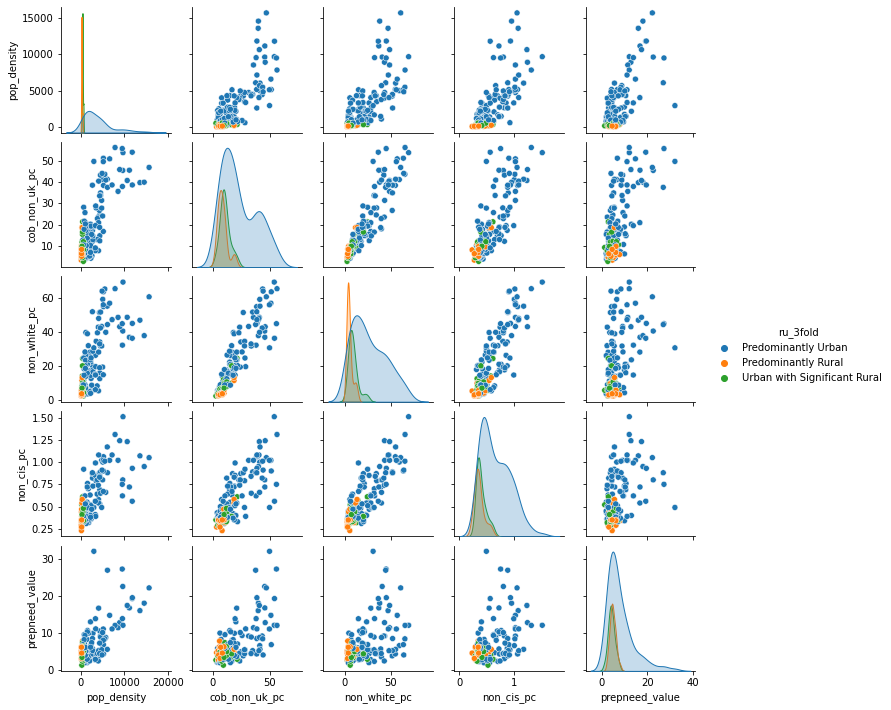

In [24]:
# Create pairplot of key vars for quick overview

pairplotdf = full_df.drop(columns=['mnemonic', '2022_local_authorities_county','ru_6fold', 'ru_2fold', 'cob_uk_pc', 'cob_africa_all_pc', 
                          'white_pc', 'black_british_pc', 'cis_pc', 'tertiary_ed_pc', 
                          'same_sex_partnership_pc', 'non_hetero_pc', 'religious_pc',
                          'prepneed_count', 'prepneed_denominator',
                          'prepuse_count', 'prepuse_denominator', 'hivnewdiag_count', 'hivnewdiag_denominator',
                          'hivprev_count', 'hivprev_denominator',
                          'prepuse_value', 'hivnewdiag_value','hivprev_value'])

pairplotdf.columns

# Index(['2022_local_authorities_county', 'mnemonic', 'pop_density', 'cob_uk_pc',
#        'cob_non_uk_pc', 'cob_africa_all_pc', 'white_pc', 'non_white_pc',
#        'black_british_pc', 'cis_pc', 'non_cis_pc', 'tertiary_ed_pc',
#        'same_sex_partnership_pc', 'non_hetero_pc', 'religious_pc', 'ru_6fold',
#        'ru_3fold', 'prepneed_value', 'prepneed_count', 'prepneed_denominator',
#        'prepuse_value', 'prepuse_count', 'prepuse_denominator',
#        'hivnewdiag_value', 'hivnewdiag_count', 'hivnewdiag_denominator',
#        'hivprev_value', 'hivprev_count', 'hivprev_denominator'],
#       dtype='object')

sns.pairplot(data=pairplotdf, hue='ru_3fold', height=2)

**Set plotting parameters**

In [6]:
# Set rural-urban category choice (uncomment desired categories)
ru_cats = "ru_2fold" 
# ru_cats = "ru_3fold" 
# ru_cats = "ru_6fold" 
# ru_cats = "ru_londonother"

# Set alpha value
scatter_alpha = 0.7

if ru_cats == "ru_2fold":
    ru_cats_order = ['Urban', 'Regional-Rural']    
    ru_cats_filename = "2cat"
elif ru_cats == "ru_3fold":
    ru_cats_order = ['Predominantly Urban', 'Urban with Significant Rural', 'Predominantly Rural']
    ru_cats_filename = "3cat"
elif ru_cats == "ru_6fold":
    ru_cats_order = ['Urban with Major Conurbation',
                 'Urban with Minor Conurbation',
                'Urban with City and Town',
                'Urban with Significant Rural',
                'Mainly Rural',
                'Largely Rural']
    ru_cats_filename = "6cat"
elif ru_cats == "ru_londonother":
    ru_cats_order = ["London", "Outside London"]
    ru_cats_filename = "londonother"
    


**Outcome (Dependent) Variable**

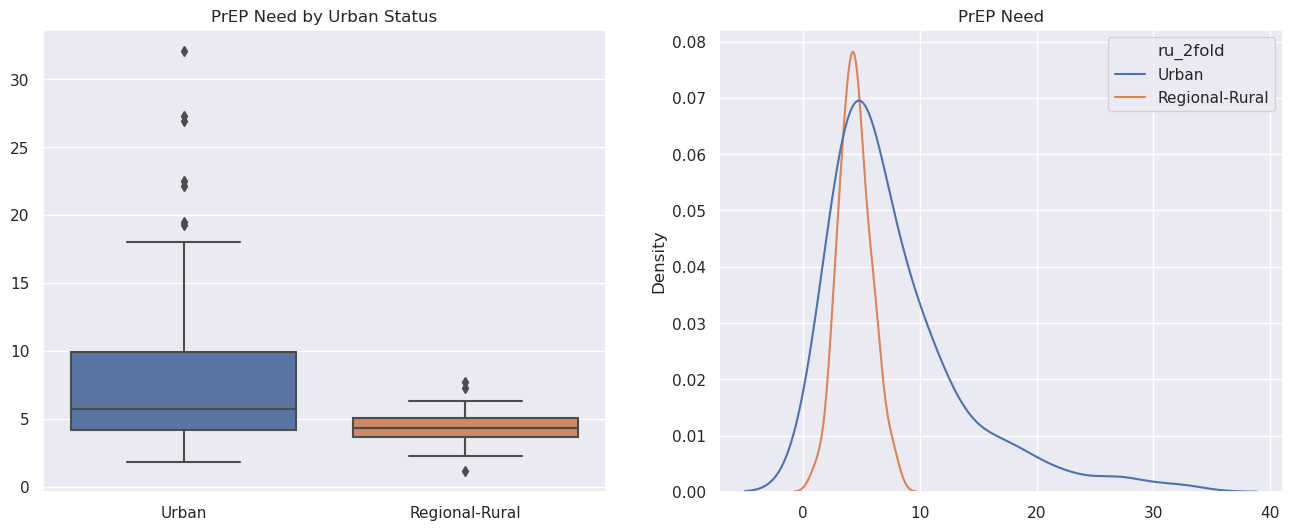

In [70]:
fig, axes = plt.subplots(1, 2, figsize = (16,6))

# create chart in each subplot
sns.boxplot(data=full_df, x=ru_cats, y='prepneed_value', order=ru_cats_order, ax=axes[0]).set(title="PrEP Need by Urban Status", xlabel = "", ylabel="")
# sns.histplot(data=full_df, x='prepneed_value', hue='ru_3fold', kde = False, ax=axes[1]).set(title="PrEP Need", xlabel = "")
sns.kdeplot(data=full_df, x='prepneed_value', hue=ru_cats, hue_order=ru_cats_order, ax=axes[1]).set(title="PrEP Need", xlabel = "")

# save figure to output folder
plt.savefig(f"figures/distplots_outcomevar_{ru_cats_filename}.png", dpi=600, facecolor="white", bbox_inches="tight")

plt.show()

Reading the figure above, PrEP need is skewed towards the right, with a small handful of counties having much higher rates compared with the mean and median values.   
**Q:** Is this skew too extreme to meet the assumptions for a normal distribution? Should a transformation be applied or outliers removed?  
**A:** Should avoid removing outliers as in this case they are likely very important to the underlying processes (e.g. the social factors which will be examined as predictors are likely part of the reason for these extreme values, not a random or unexpected oddity). ALSO, do not necessarily require a normal distribution of the values for a linear regression; just of the residuals. 

**HIV & PrEP Variables**

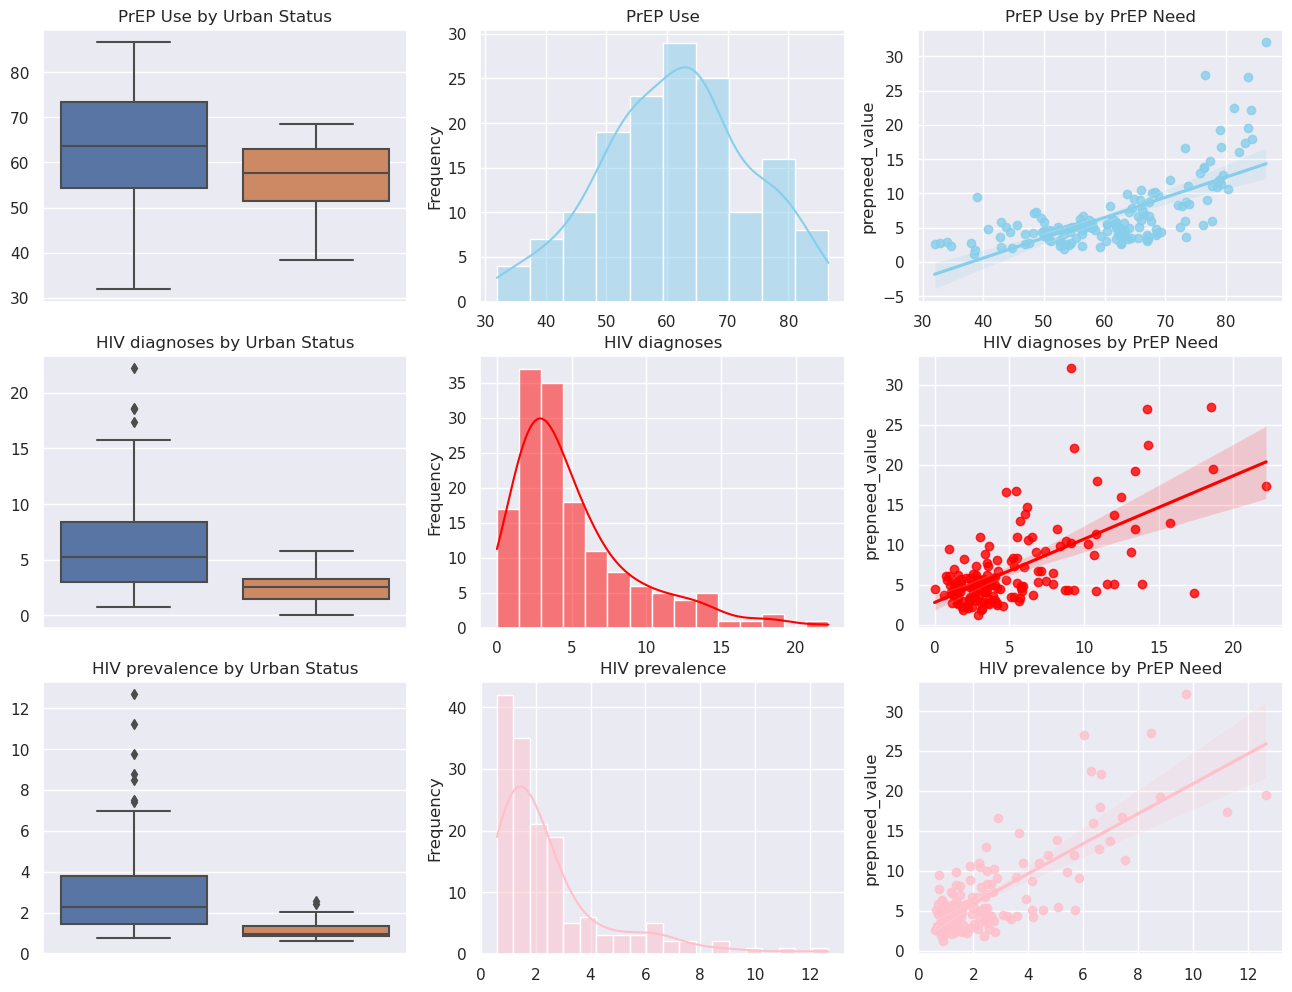

In [84]:
#define dimensions of subplots (rows, columns)
fig, axes = plt.subplots(3, 3, figsize = (16,12))

#set theme
sns.set(style="darkgrid")

sns.boxplot(data=full_df, x=ru_cats, y='prepuse_value', order=ru_cats_order, ax=axes[0,0]).set(title="PrEP Use by Urban Status", 
                                                                            xticklabels=[], xlabel=None, ylabel=None)
sns.histplot(data=full_df, x='prepuse_value', color = "skyblue", kde = True, ax=axes[0,1]).set(title="PrEP Use", 
                                                                                                  xlabel = "", ylabel="Frequency")
# sns.scatterplot(data=full_df, x='prepuse_value', y='prepneed_value',  hue = ru_cats, alpha = scatter_alpha,
#                 ax=axes[0,2], legend=False).set(title="PrEP Use by PrEP Need", xlabel = "")
sns.regplot(data=full_df, x='prepuse_value', y='prepneed_value', color = "skyblue", ax=axes[0,2]).set(title="PrEP Use by PrEP Need", xlabel = "")


sns.boxplot(data=full_df, x=ru_cats, y='hivnewdiag_value', order=ru_cats_order, ax=axes[1,0]).set(title="HIV diagnoses by Urban Status", 
                                                                            xticklabels=[], xlabel=None, ylabel=None)
sns.histplot(data=full_df, x='hivnewdiag_value', color = "red", kde = True, ax=axes[1,1]).set(title="HIV diagnoses", 
                                                                                                  xlabel = "", ylabel="Frequency")
# sns.scatterplot(data=full_df, x='hivnewdiag_value', y='prepneed_value',  hue = ru_cats, alpha = scatter_alpha,
#                 ax=axes[1,2], legend=False).set(title="HIV New Diagnoses by PrEP Need", xlabel = "")
sns.regplot(data=full_df, x='hivnewdiag_value', y='prepneed_value', color = "red", ax=axes[1,2]).set(title="HIV diagnoses by PrEP Need", xlabel = "")


sns.boxplot(data=full_df, x=ru_cats, y='hivprev_value', order=ru_cats_order, ax=axes[2,0]).set(title="HIV prevalence by Urban Status", 
                                                                            xticklabels=[], xlabel=None, ylabel=None)
sns.histplot(data=full_df, x='hivprev_value', color = "pink", kde = True, ax=axes[2,1]).set(title="HIV prevalence", 
                                                                                                  xlabel = "", ylabel="Frequency")
# sns.scatterplot(data=full_df, x='hivprev_value', y='prepneed_value',  hue = ru_cats, alpha = scatter_alpha,
#                 ax=axes[2,2], legend=False).set(title="HIV Prevalence by PrEP Need", xlabel = "")
sns.regplot(data=full_df, x='hivprev_value', y='prepneed_value', color = "pink", ax=axes[2,2]).set(title="HIV prevalence by PrEP Need", xlabel = "")


# save figure to output folder
plt.savefig(f"figures/distplots_hivpredictors_{ru_cats_filename}.png", dpi=600, facecolor="white", bbox_inches="tight")

plt.show()

**Predictor Variables**

Census predictors:

1. Per cent born outside uk (*cob_non_uk_pc*)
 
2. Per cent non white ethnicity (*non_white_pc*)
 
    2.1 Per cent black british ethnicity (*black_british_pc*)

3. Per cent non cisgender (*non_cis_pc*)
 
4. Per cent LGB+ (*non_hetero_pc*)
 
5. Per cent religious (*religious_pc*)

6. Per cent tertiary educated (*tertiary_ed_pc*)
 

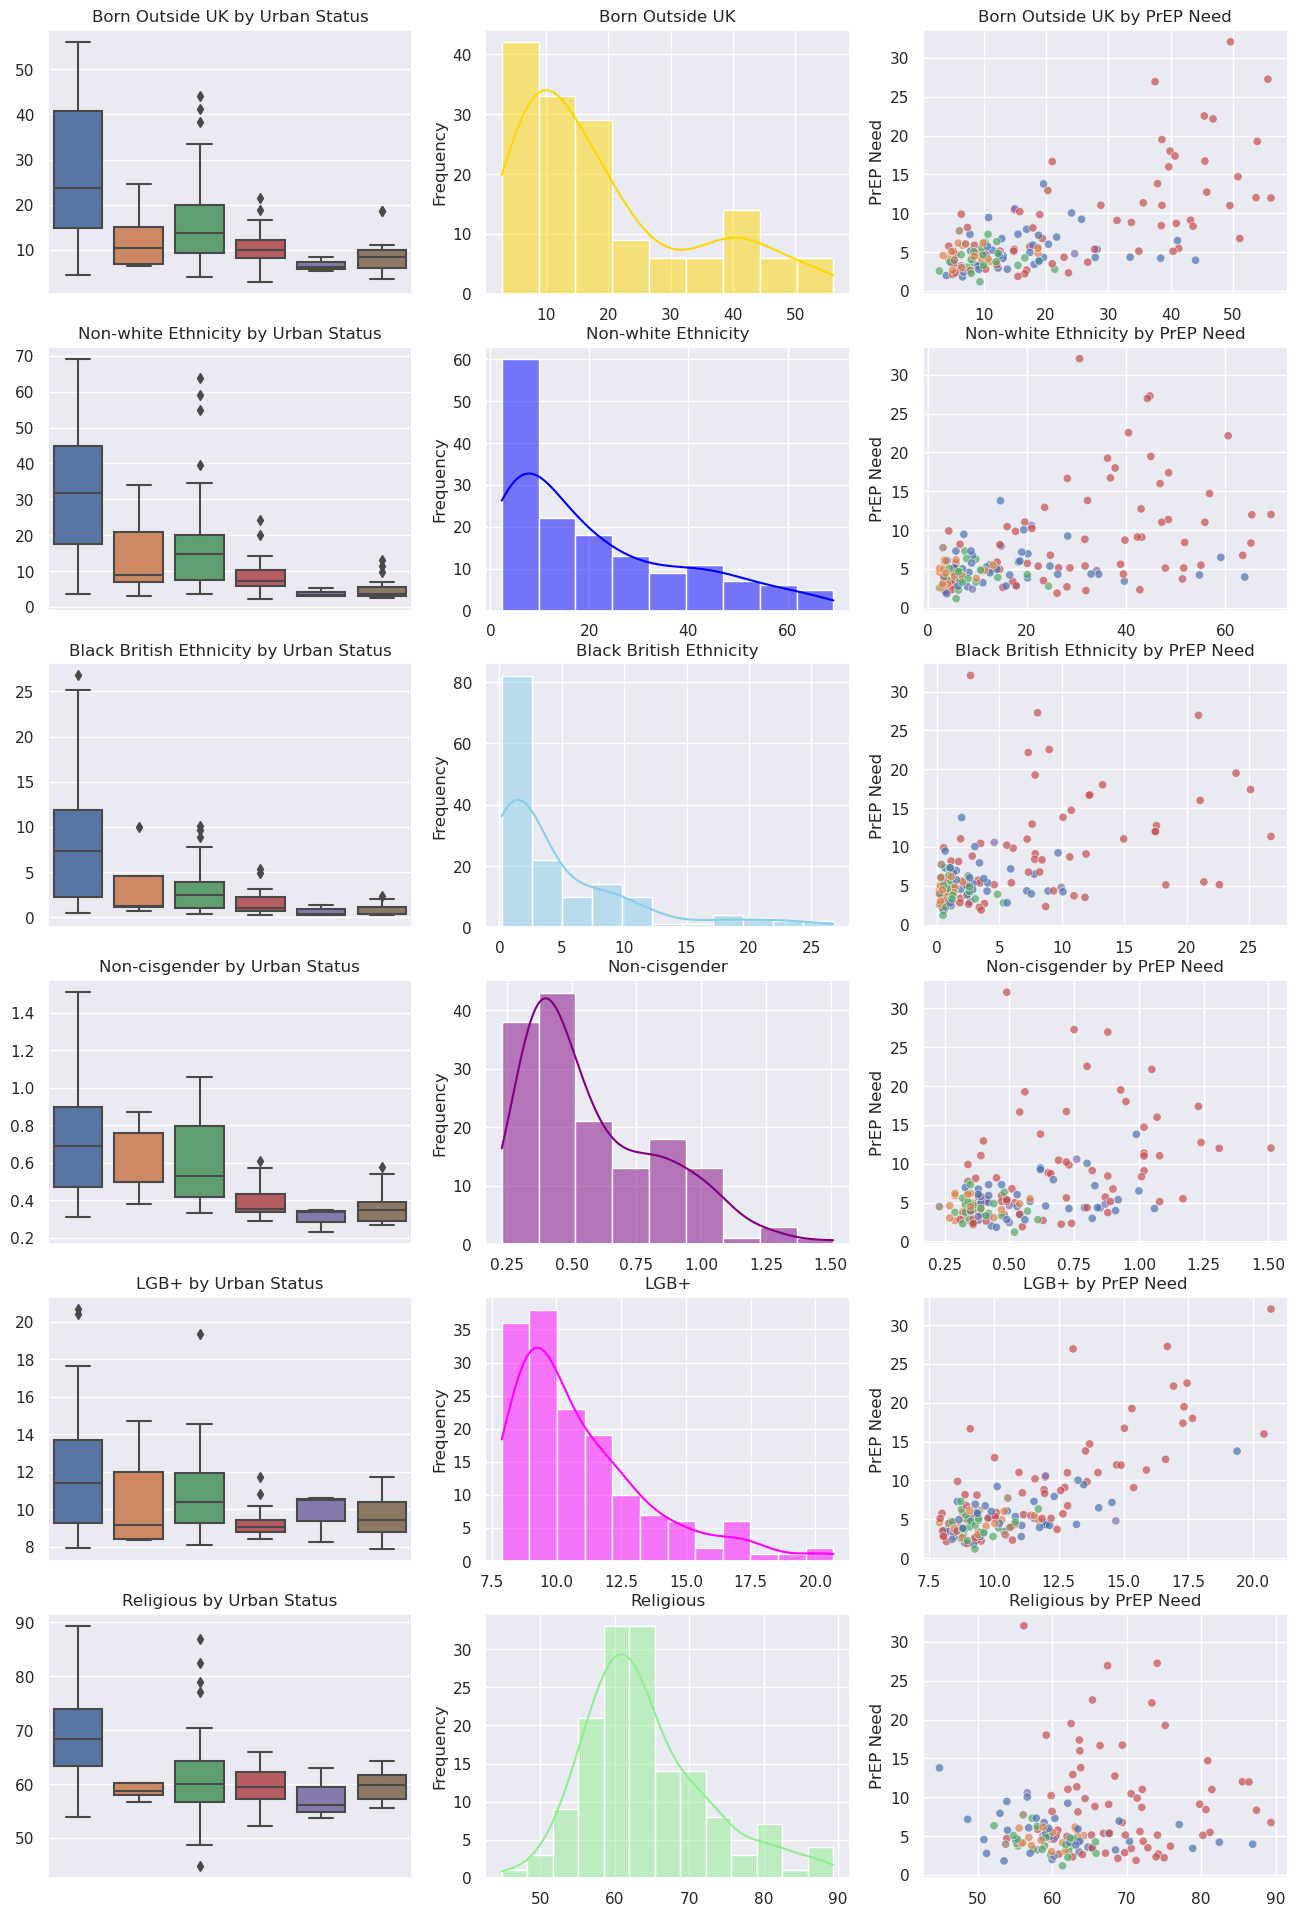

In [47]:
#define dimensions of subplots (rows, columns)
fig, axes = plt.subplots(6, 3, figsize = (16,24))

#set theme
sns.set(style="darkgrid")

#create chart in each subplot
sa1 = sns.boxplot(data=full_df, x=ru_cats, y='cob_non_uk_pc', order=ru_cats_order, ax=axes[0,0]).set(title="Born Outside UK by Urban Status", 
                                                                            xticklabels=[], xlabel=None, ylabel=None)
sb1 = sns.histplot(data=full_df, x='cob_non_uk_pc', color = "gold", kde = True, ax=axes[0,1]).set(title="Born Outside UK", 
                                                                                                  xlabel = "", ylabel="Frequency")
sc1 = sns.scatterplot(data=full_df, x='cob_non_uk_pc', y='prepneed_value', hue = ru_cats, alpha = scatter_alpha, 
                ax=axes[0,2], legend=False).set(title="Born Outside UK by PrEP Need", xlabel = "", ylabel = "PrEP Need")

sa2 = sns.boxplot(data=full_df, x=ru_cats, y='non_white_pc', order=ru_cats_order, ax=axes[1,0]).set(title="Non-white Ethnicity by Urban Status", 
                                                                            xticklabels=[], xlabel=None, ylabel=None)
sb2 = sns.histplot(data=full_df, x='non_white_pc', color = "blue", kde = True, ax=axes[1,1]).set(title="Non-white Ethnicity", 
                                                                                                 xlabel = "", ylabel="Frequency")
sc2 = sns.scatterplot(data=full_df, x='non_white_pc', y='prepneed_value',  hue = ru_cats, alpha = scatter_alpha,
                ax=axes[1,2], legend=False).set(title="Non-white Ethnicity by PrEP Need", xlabel = "", ylabel = "PrEP Need")

sa3 = sns.boxplot(data=full_df, x=ru_cats, y='black_british_pc', order=ru_cats_order, ax=axes[2,0]).set(title="Black British Ethnicity by Urban Status", 
                                                                            xticklabels=[], xlabel=None, ylabel=None)
sb3 = sns.histplot(data=full_df, x='black_british_pc', color = "skyblue", kde = True, ax=axes[2,1]).set(title="Black British Ethnicity", 
                                                                                                        xlabel = "", ylabel="Frequency")
sc3 = sns.scatterplot(data=full_df, x='black_british_pc', y='prepneed_value', hue = ru_cats, alpha = scatter_alpha,
                ax=axes[2,2], legend=False).set(title="Black British Ethnicity by PrEP Need", xlabel = "", ylabel = "PrEP Need")

sa4 = sns.boxplot(data=full_df, x=ru_cats, y='non_cis_pc', order=ru_cats_order, ax=axes[3,0]).set(title="Non-cisgender by Urban Status", 
                                                                            xticklabels=[], xlabel=None, ylabel=None)
sb4 = sns.histplot(data=full_df, x='non_cis_pc', color = "purple", kde = True, ax=axes[3,1]).set(title="Non-cisgender", 
                                                                                               xlabel = "", ylabel="Frequency")
sc4 = sns.scatterplot(data=full_df, x='non_cis_pc', y='prepneed_value',  hue = ru_cats, alpha = scatter_alpha,
                ax=axes[3,2], legend=False).set(title="Non-cisgender by PrEP Need", xlabel = "", ylabel = "PrEP Need")

sa5 = sns.boxplot(data=full_df, x=ru_cats, y='non_hetero_pc', order=ru_cats_order, ax=axes[4,0]).set(title="LGB+ by Urban Status", 
                                                                            xticklabels=[], xlabel=None, ylabel=None)
sb5 = sns.histplot(data=full_df, x='non_hetero_pc', color = "magenta", kde = True, ax=axes[4,1]).set(title="LGB+", 
                                                                                                     xlabel = "", ylabel="Frequency")
sc5 = sns.scatterplot(data=full_df, x='non_hetero_pc', y='prepneed_value',  hue = ru_cats, alpha = scatter_alpha,
                ax=axes[4,2], legend=False).set(title="LGB+ by PrEP Need", xlabel = "", ylabel = "PrEP Need")

sa6 = sns.boxplot(data=full_df, x=ru_cats, y='religious_pc', order=ru_cats_order, ax=axes[5,0]).set(title="Religious by Urban Status", 
                                                                            xticklabels=[], xlabel=None, ylabel=None)
sb6 = sns.histplot(data=full_df, x='religious_pc', color = "lightgreen", kde = True, ax=axes[5,1]).set(title="Religious", 
                                                                                                       xlabel = "", ylabel="Frequency")
sc6 = sns.scatterplot(data=full_df, x='religious_pc', y='prepneed_value',  hue = ru_cats, alpha = scatter_alpha,
                ax=axes[5,2], legend=False).set(title="Religious by PrEP Need", xlabel = "", ylabel = "PrEP Need")

# create shared legend
# plt.legend(loc='upper right')

# save figure to output folder
plt.savefig(f"figures/distplots_censuspredictors_{ru_cats_filename}.png", dpi=600, facecolor="white", bbox_inches="tight")


plt.show()

## 3. Analysis

### 3.1 Correlation Matrix

In [48]:
full_df.columns

Index(['2022_local_authorities_county', 'mnemonic', 'pop_density', 'cob_uk_pc',
       'cob_non_uk_pc', 'cob_africa_all_pc', 'white_pc', 'non_white_pc',
       'black_british_pc', 'cis_pc', 'non_cis_pc', 'tertiary_ed_pc',
       'same_sex_partnership_pc', 'non_hetero_pc', 'religious_pc', 'ru_6fold',
       'ru_3fold', 'ru_2fold', 'prepneed_value', 'prepneed_count',
       'prepneed_denominator', 'prepuse_value', 'prepuse_count',
       'prepuse_denominator', 'hivnewdiag_value', 'hivnewdiag_count',
       'hivnewdiag_denominator', 'hivprev_value', 'hivprev_count',
       'hivprev_denominator'],
      dtype='object')

In [65]:
# Select only desired variables
ols_df = full_df[['2022_local_authorities_county', 'pop_density', 
                  'cob_non_uk_pc', 'non_white_pc', 'black_british_pc', 
                  'non_cis_pc', 'non_hetero_pc', 'religious_pc', 
                  'tertiary_ed_pc', 
                  # 'same_sex_partnership_pc', 
                  # 'ru_6fold', 'ru_3fold', 'ru_2fold', 
                  'prepneed_value', 
                  # 'prepneed_count', 'prepneed_denominator', 
                  # 'prepuse_value', 
                  # 'prepuse_count', 'prepuse_denominator', 
                  'hivnewdiag_value', 
                  # 'hivnewdiag_count', 'hivnewdiag_denominator', 
                  'hivprev_value', 
                  # 'hivprev_count', 'hivprev_denominator'
                 ]].set_index('2022_local_authorities_county')

ols_df

,pop_density,cob_non_uk_pc,non_white_pc,black_british_pc,non_cis_pc,non_hetero_pc,religious_pc,tertiary_ed_pc,prepneed_value,hivnewdiag_value,hivprev_value
2022_local_authorities_county,,,,,,,,,,,
Darlington,545.9,7.8,5.63,0.65,0.42,8.58,60.32,28.96,7.2937,2.7932,1.2246
County Durham,234.5,4.4,3.18,0.33,0.37,8.62,61.37,26.74,4.1320,1.6881,0.8370
Hartlepool,985.5,4.0,3.54,0.48,0.43,8.86,59.94,24.81,1.9917,3.1971,0.9328
Middlesbrough,2671.2,12.3,17.63,2.65,0.82,10.45,63.58,26.44,2.9589,5.6623,1.3364
Northumberland,63.9,3.5,2.35,0.19,0.27,7.89,59.85,30.74,4.5785,1.5441,0.7173
...,...,...,...,...,...,...,...,...,...,...,...
Wiltshire,156.8,9.9,5.67,1.13,0.35,9.06,58.73,34.17,6.1702,1.5871,0.8533
Devon,123.7,7.1,3.60,0.30,0.34,10.39,55.51,32.87,6.0386,0.9868,0.8997
Dorset,152.4,6.5,2.94,0.28,0.27,9.38,59.89,31.47,3.0166,1.8431,0.8735


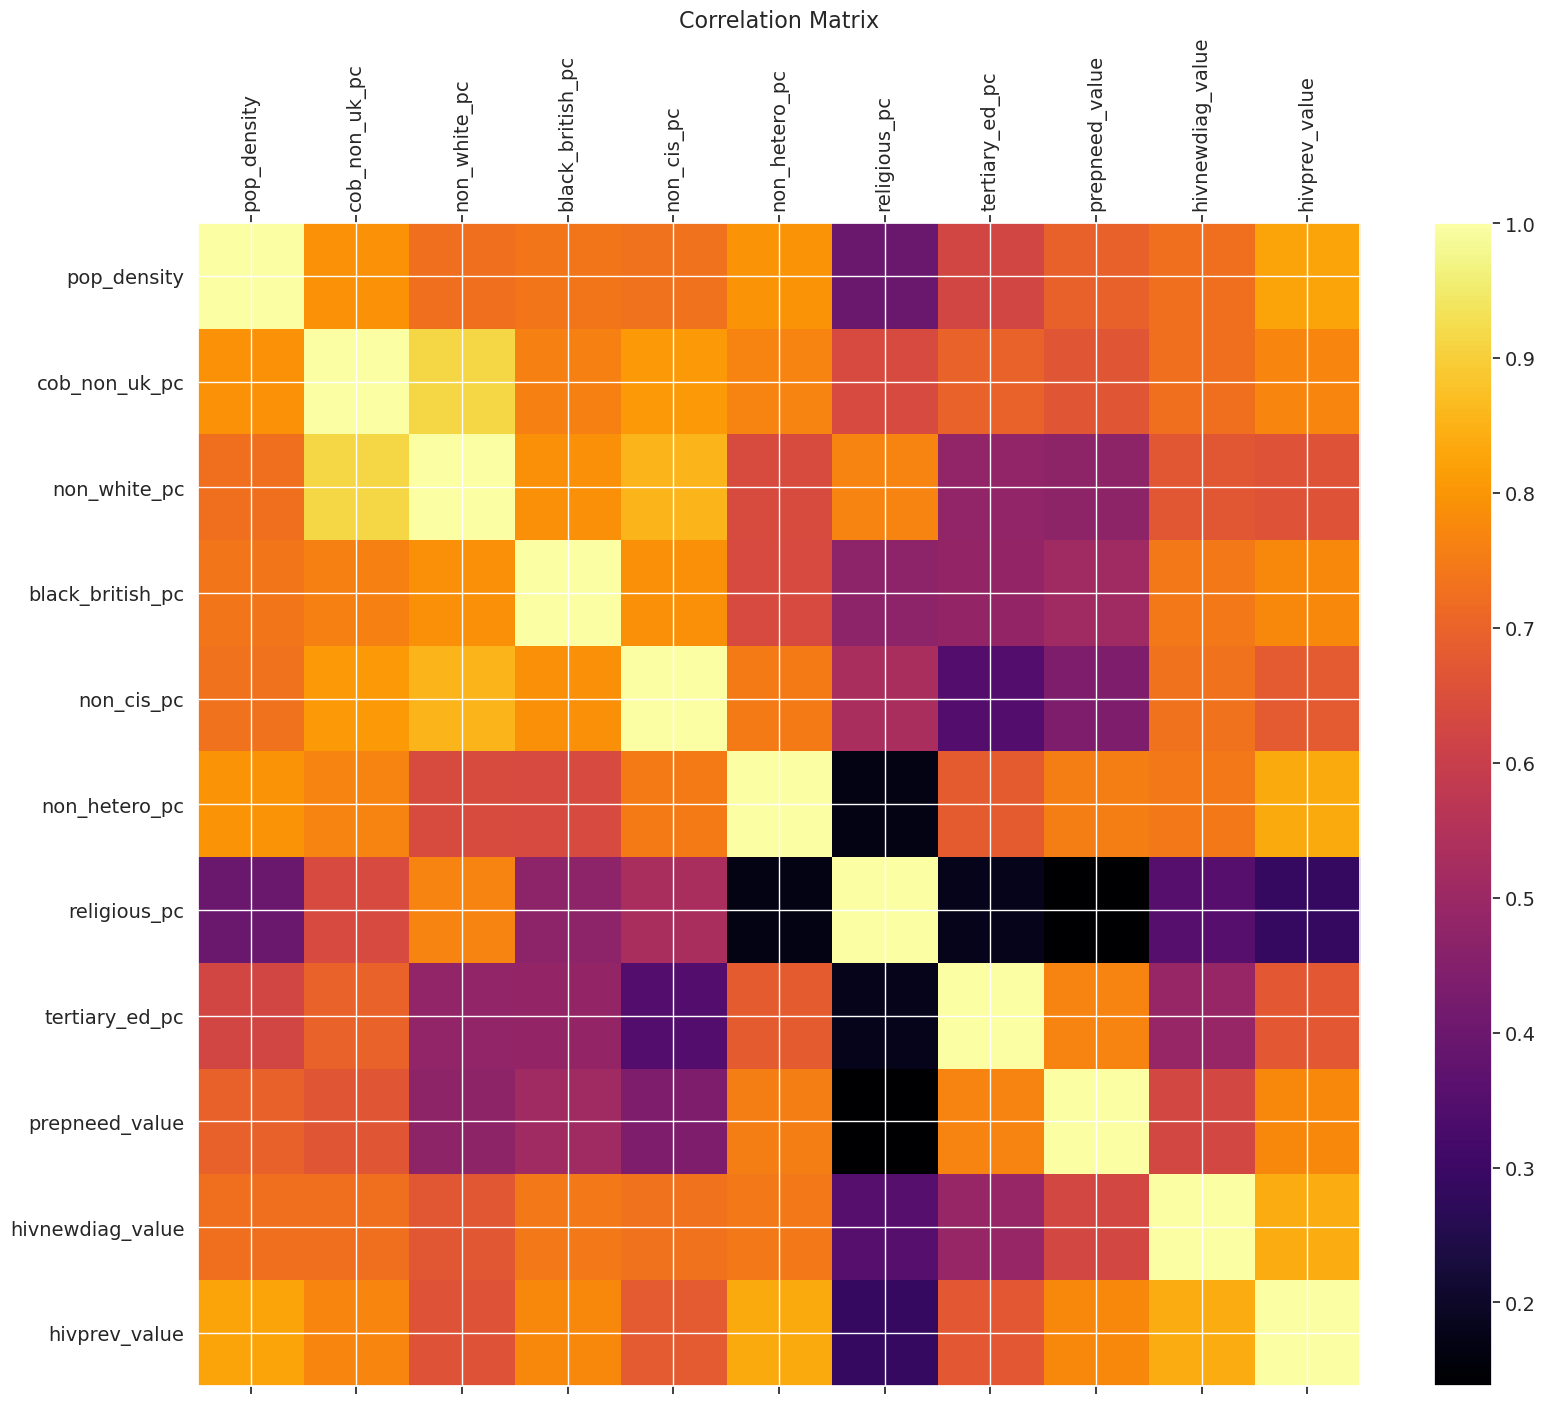

In [66]:
f = plt.figure(figsize=(19, 15))
plt.matshow(ols_df.corr(), fignum=f.number, cmap="inferno")
plt.xticks(range(ols_df.shape[1]), ols_df.columns, fontsize=14, rotation=90)
plt.yticks(range(ols_df.shape[1]), ols_df.columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Correlation Matrix', fontsize=16)

plt.savefig("figures/corrplot.png", dpi=600, facecolor="white", bbox_inches="tight")

### 3.2 VIF

In [67]:
vif_data = pd.DataFrame()
vif_data["feature"] = ols_df.columns
  
# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(ols_df.values, i)
                          for i in range(len(ols_df.columns))]
  
vif_data

,feature,VIF
0,pop_density,7.438770
1,cob_non_uk_pc,44.558518
2,non_white_pc,32.997533
3,black_british_pc,8.796597
4,non_cis_pc,61.715952
5,non_hetero_pc,122.471171
6,religious_pc,39.011047
7,tertiary_ed_pc,63.940699
8,prepneed_value,11.306502
9,hivnewdiag_value,11.067774


In [59]:
# calculating VIF
# This function is adjusted from: https://stackoverflow.com/a/51329496/4667568
from statsmodels.stats.outliers_influence import variance_inflation_factor 
from statsmodels.tools.tools import add_constant

def drop_column_using_vif_(df, thresh=10):
    '''
    Calculates VIF each feature in a pandas dataframe, and repeatedly drop the columns with the highest VIF
    A constant must be added to variance_inflation_factor or the results will be incorrect

    :param df: the pandas dataframe containing only the predictor features, not the response variable
    :param thresh: (default 5) the threshould VIF value. If the VIF of a variable is greater than thresh, it should be removed from the dataframe
    :return: dataframe with multicollinear features removed
    '''
    while True:
        # adding a constant item to the data. add_constant is a function from statsmodels (see the import above)
        df_with_const = add_constant(df)

        vif_df = pd.Series([variance_inflation_factor(df_with_const.values, i) 
               for i in range(df_with_const.shape[1])], name= "VIF",
              index=df_with_const.columns).to_frame()

        # drop the const
        vif_df = vif_df.drop('const')
        
        # if the largest VIF is above the thresh, remove a variable with the largest VIF
        # If there are multiple variabels with VIF>thresh, only one of them is removed. This is because we want to keep as many variables as possible
        if vif_df.VIF.max() > thresh:
            # If there are multiple variables with the maximum VIF, choose the first one
            index_to_drop = vif_df.index[vif_df.VIF == vif_df.VIF.max()].tolist()[0]
            print('Dropping: {}'.format(index_to_drop))
            df = df.drop(columns = index_to_drop)
        else:
            # No VIF is above threshold. Exit the loop
            break

    return df

In [68]:
vif_output = drop_column_using_vif_(ols_df.drop(columns='prepneed_value'))

vif_output

Dropping: non_white_pc
Dropping: cob_non_uk_pc


,pop_density,black_british_pc,non_cis_pc,non_hetero_pc,religious_pc,tertiary_ed_pc,hivnewdiag_value,hivprev_value
2022_local_authorities_county,,,,,,,,
Darlington,545.9,0.65,0.42,8.58,60.32,28.96,2.7932,1.2246
County Durham,234.5,0.33,0.37,8.62,61.37,26.74,1.6881,0.8370
Hartlepool,985.5,0.48,0.43,8.86,59.94,24.81,3.1971,0.9328
Middlesbrough,2671.2,2.65,0.82,10.45,63.58,26.44,5.6623,1.3364
Northumberland,63.9,0.19,0.27,7.89,59.85,30.74,1.5441,0.7173
...,...,...,...,...,...,...,...,...
Wiltshire,156.8,1.13,0.35,9.06,58.73,34.17,1.5871,0.8533
Devon,123.7,0.30,0.34,10.39,55.51,32.87,0.9868,0.8997
Dorset,152.4,0.28,0.27,9.38,59.89,31.47,1.8431,0.8735


### 3.5 Create dummy variables for urban-rural categories

In [35]:
ru_dummies = full_df[['2022_local_authorities_county','ru_6fold', 'ru_3fold', 'ru_2fold']].set_index('2022_local_authorities_county')
ru_dummies = pd.get_dummies(ru_dummies)

In [36]:
# Join dummies back onto main dataframe
ols_df = clean_columns(pd.merge(ols_df, ru_dummies, left_index=True, right_index=True))
ols_df

11 column names have been cleaned

,pop_density,cob_non_uk_pc,non_white_pc,black_british_pc,non_cis_pc,non_hetero_pc,religious_pc,prepneed_value,hivnewdiag_value,hivprev_value,...,ru_6fold_mainly_rural,ru_6fold_urban_with_city_and_town,ru_6fold_urban_with_major_conurbation,ru_6fold_urban_with_minor_conurbation,ru_6fold_urban_with_significant_rural,ru_3fold_predominantly_rural,ru_3fold_predominantly_urban,ru_3fold_urban_with_significant_rural,ru_2fold_regional_rural,ru_2fold_urban
2022_local_authorities_county,,,,,,,,,,,,,,,,,,,,,
Darlington,545.9,7.8,5.63,0.65,0.42,8.58,60.32,7.2937,2.7932,1.2246,...,0,1,0,0,0,0,1,0,0,1
County Durham,234.5,4.4,3.18,0.33,0.37,8.62,61.37,4.1320,1.6881,0.8370,...,0,0,0,0,0,1,0,0,1,0
Hartlepool,985.5,4.0,3.54,0.48,0.43,8.86,59.94,1.9917,3.1971,0.9328,...,0,1,0,0,0,0,1,0,0,1
Middlesbrough,2671.2,12.3,17.63,2.65,0.82,10.45,63.58,2.9589,5.6623,1.3364,...,0,1,0,0,0,0,1,0,0,1
Northumberland,63.9,3.5,2.35,0.19,0.27,7.89,59.85,4.5785,1.5441,0.7173,...,0,0,0,0,0,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Wiltshire,156.8,9.9,5.67,1.13,0.35,9.06,58.73,6.1702,1.5871,0.8533,...,0,0,0,0,0,1,0,0,1,0
Devon,123.7,7.1,3.60,0.30,0.34,10.39,55.51,6.0386,0.9868,0.8997,...,0,0,0,0,0,1,0,0,1,0
Dorset,152.4,6.5,2.94,0.28,0.27,9.38,59.89,3.0166,1.8431,0.8735,...,0,0,0,0,0,1,0,0,1,0


### 3.4 OLS Linear Regression

In [37]:
model1_all = ols('prepneed_value ~  pop_density + cob_non_uk_pc + non_white_pc + non_cis_pc + non_hetero_pc + religious_pc + hivnewdiag_value + hivprev_value + ru_2fold_regional_rural', ols_df).fit()

print(model1_all.summary())

                            OLS Regression Results                            
Dep. Variable:         prepneed_value   R-squared:                       0.752
Model:                            OLS   Adj. R-squared:                  0.737
Method:                 Least Squares   F-statistic:                     47.63
Date:                Mon, 16 Jan 2023   Prob (F-statistic):           1.89e-38
Time:                        08:34:14   Log-Likelihood:                -358.01
No. Observations:                 151   AIC:                             736.0
Df Residuals:                     141   BIC:                             766.2
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                 

In [38]:
model1_viflist_threshold5 =  ols('prepneed_value ~  pop_density + black_british_pc + non_cis_pc + religious_pc + hivnewdiag_value', ols_df).fit()

# print(model1_viflist_threshold5.summary())

In [39]:
model1_viflist_threshold10 = ols('prepneed_value ~  pop_density + cob_non_uk_pc + black_british_pc + non_cis_pc + non_hetero_pc + religious_pc + hivnewdiag_value + hivprev_value', ols_df).fit()

print(model1_viflist_threshold10.summary())

                            OLS Regression Results                            
Dep. Variable:         prepneed_value   R-squared:                       0.747
Model:                            OLS   Adj. R-squared:                  0.733
Method:                 Least Squares   F-statistic:                     52.38
Date:                Mon, 16 Jan 2023   Prob (F-statistic):           1.18e-38
Time:                        08:34:14   Log-Likelihood:                -359.69
No. Observations:                 151   AIC:                             737.4
Df Residuals:                     142   BIC:                             764.5
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            3.2288      4.038  

In [40]:
model2_sigonly = ols('prepneed_value ~ cob_non_uk_pc + non_cis_pc + non_hetero_pc + hivprev_value', ols_df).fit()

print(model2_sigonly.summary())

                            OLS Regression Results                            
Dep. Variable:         prepneed_value   R-squared:                       0.738
Model:                            OLS   Adj. R-squared:                  0.731
Method:                 Least Squares   F-statistic:                     102.7
Date:                Mon, 16 Jan 2023   Prob (F-statistic):           1.99e-41
Time:                        08:34:14   Log-Likelihood:                -362.36
No. Observations:                 151   AIC:                             734.7
Df Residuals:                     146   BIC:                             749.8
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        -3.2288      1.334     -2.421

### 3.5 Testing regression assumptions

In [41]:
# Set functions for regression plots
style_talk = 'seaborn-talk'    #refer to plt.style.available

class Linear_Reg_Diagnostic():
    """
    Diagnostic plots to identify potential problems in a linear regression fit.
    Mainly,
        a. non-linearity of data
        b. Correlation of error terms
        c. non-constant variance
        d. outliers
        e. high-leverage points
        f. collinearity

    Author:
        Prajwal Kafle (p33ajkafle@gmail.com, where 3 = r)
        Does not come with any sort of warranty.
        Please test the code one your end before using.
    """

    def __init__(self,
                 results: Type[statsmodels.regression.linear_model.RegressionResultsWrapper]) -> None:
        """
        For a linear regression model, generates following diagnostic plots:

        a. residual
        b. qq
        c. scale location and
        d. leverage

        and a table

        e. vif

        Args:
            results (Type[statsmodels.regression.linear_model.RegressionResultsWrapper]):
                must be instance of statsmodels.regression.linear_model object

        Raises:
            TypeError: if instance does not belong to above object

        Example:
        >>> import numpy as np
        >>> import pandas as pd
        >>> import statsmodels.formula.api as smf
        >>> x = np.linspace(-np.pi, np.pi, 100)
        >>> y = 3*x + 8 + np.random.normal(0,1, 100)
        >>> df = pd.DataFrame({'x':x, 'y':y})
        >>> res = smf.ols(formula= "y ~ x", data=df).fit()
        >>> cls = Linear_Reg_Diagnostic(res)
        >>> cls(plot_context="seaborn-paper")

        In case you do not need all plots you can also independently make an individual plot/table
        in following ways

        >>> cls = Linear_Reg_Diagnostic(res)
        >>> cls.residual_plot()
        >>> cls.qq_plot()
        >>> cls.scale_location_plot()
        >>> cls.leverage_plot()
        >>> cls.vif_table()
        """

        if isinstance(results, statsmodels.regression.linear_model.RegressionResultsWrapper) is False:
            raise TypeError("result must be instance of statsmodels.regression.linear_model.RegressionResultsWrapper object")

        self.results = maybe_unwrap_results(results)

        self.y_true = self.results.model.endog
        self.y_predict = self.results.fittedvalues
        self.xvar = self.results.model.exog
        self.xvar_names = self.results.model.exog_names

        self.residual = np.array(self.results.resid)
        influence = self.results.get_influence()
        self.residual_norm = influence.resid_studentized_internal
        self.leverage = influence.hat_matrix_diag
        self.cooks_distance = influence.cooks_distance[0]
        self.nparams = len(self.results.params)

    def __call__(self, plot_context='seaborn-paper'):
        # print(plt.style.available)
        with plt.style.context(plot_context):
            fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(10,10))
            self.residual_plot(ax=ax[0,0])
            self.qq_plot(ax=ax[0,1])
            self.scale_location_plot(ax=ax[1,0])
            self.leverage_plot(ax=ax[1,1])
            plt.show()

        self.vif_table()
        return fig, ax


    def residual_plot(self, ax=None):
        """
        Residual vs Fitted Plot

        Graphical tool to identify non-linearity.
        (Roughly) Horizontal red line is an indicator that the residual has a linear pattern
        """
        if ax is None:
            fig, ax = plt.subplots()

        sns.residplot(
            x=self.y_predict,
            y=self.residual,
            lowess=True,
            scatter_kws={'alpha': 0.5},
            line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8},
            ax=ax)

        # annotations
        residual_abs = np.abs(self.residual)
        abs_resid = np.flip(np.sort(residual_abs))
        abs_resid_top_3 = abs_resid[:3]
        for i, _ in enumerate(abs_resid_top_3):
            ax.annotate(
                i,
                xy=(self.y_predict[i], self.residual[i]),
                color='C3')

        ax.set_title('Residuals vs Fitted', fontweight="bold")
        ax.set_xlabel('Fitted values')
        ax.set_ylabel('Residuals')
        return ax

    def qq_plot(self, ax=None):
        """
        Standarized Residual vs Theoretical Quantile plot

        Used to visually check if residuals are normally distributed.
        Points spread along the diagonal line will suggest so.
        """
        if ax is None:
            fig, ax = plt.subplots()

        QQ = ProbPlot(self.residual_norm)
        QQ.qqplot(line='45', alpha=0.5, lw=1, ax=ax)

        # annotations
        abs_norm_resid = np.flip(np.argsort(np.abs(self.residual_norm)), 0)
        abs_norm_resid_top_3 = abs_norm_resid[:3]
        for r, i in enumerate(abs_norm_resid_top_3):
            ax.annotate(
                i,
                xy=(np.flip(QQ.theoretical_quantiles, 0)[r], self.residual_norm[i]),
                ha='right', color='C3')

        ax.set_title('Normal Q-Q', fontweight="bold")
        ax.set_xlabel('Theoretical Quantiles')
        ax.set_ylabel('Standardized Residuals')
        return ax

    def scale_location_plot(self, ax=None):
        """
        Sqrt(Standarized Residual) vs Fitted values plot

        Used to check homoscedasticity of the residuals.
        Horizontal line will suggest so.
        """
        if ax is None:
            fig, ax = plt.subplots()

        residual_norm_abs_sqrt = np.sqrt(np.abs(self.residual_norm))

        ax.scatter(self.y_predict, residual_norm_abs_sqrt, alpha=0.5);
        sns.regplot(
            x=self.y_predict,
            y=residual_norm_abs_sqrt,
            scatter=False, ci=False,
            lowess=True,
            line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8},
            ax=ax)

        # annotations
        abs_sq_norm_resid = np.flip(np.argsort(residual_norm_abs_sqrt), 0)
        abs_sq_norm_resid_top_3 = abs_sq_norm_resid[:3]
        for i in abs_sq_norm_resid_top_3:
            ax.annotate(
                i,
                xy=(self.y_predict[i], residual_norm_abs_sqrt[i]),
                color='C3')
        ax.set_title('Scale-Location', fontweight="bold")
        ax.set_xlabel('Fitted values')
        ax.set_ylabel(r'$\sqrt{|\mathrm{Standardized\ Residuals}|}$');
        return ax

    def leverage_plot(self, ax=None):
        """
        Residual vs Leverage plot

        Points falling outside Cook's distance curves are considered observation that can sway the fit
        aka are influential.
        Good to have none outside the curves.
        """
        if ax is None:
            fig, ax = plt.subplots()

        ax.scatter(
            self.leverage,
            self.residual_norm,
            alpha=0.5);

        sns.regplot(
            x=self.leverage,
            y=self.residual_norm,
            scatter=False,
            ci=False,
            lowess=True,
            line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8},
            ax=ax)

        # annotations
        leverage_top_3 = np.flip(np.argsort(self.cooks_distance), 0)[:3]
        for i in leverage_top_3:
            ax.annotate(
                i,
                xy=(self.leverage[i], self.residual_norm[i]),
                color = 'C3')

        xtemp, ytemp = self.__cooks_dist_line(0.5) # 0.5 line
        ax.plot(xtemp, ytemp, label="Cook's distance", lw=1, ls='--', color='red')
        xtemp, ytemp = self.__cooks_dist_line(1) # 1 line
        ax.plot(xtemp, ytemp, lw=1, ls='--', color='red')

        ax.set_xlim(0, max(self.leverage)+0.01)
        ax.set_title('Residuals vs Leverage', fontweight="bold")
        ax.set_xlabel('Leverage')
        ax.set_ylabel('Standardized Residuals')
        ax.legend(loc='upper right')
        return ax

    def vif_table(self):
        """
        VIF table

        VIF, the variance inflation factor, is a measure of multicollinearity.
        VIF > 5 for a variable indicates that it is highly collinear with the
        other input variables.
        """
        vif_df = pd.DataFrame()
        vif_df["Features"] = self.xvar_names
        vif_df["VIF Factor"] = [variance_inflation_factor(self.xvar, i) for i in range(self.xvar.shape[1])]

        print(vif_df
                .sort_values("VIF Factor")
                .round(2))


    def __cooks_dist_line(self, factor):
        """
        Helper function for plotting Cook's distance curves
        """
        p = self.nparams
        formula = lambda x: np.sqrt((factor * p * (1 - x)) / x)
        x = np.linspace(0.001, max(self.leverage), 50)
        y = formula(x)
        return x, y

<AxesSubplot:title={'center':'Residuals vs Fitted'}, xlabel='Fitted values', ylabel='Residuals'>

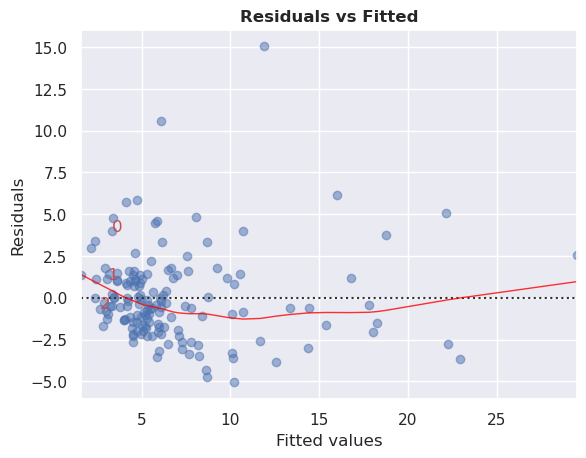

In [42]:
cls = Linear_Reg_Diagnostic(model2_sigonly)
cls.residual_plot()

<Figure size 1200x1600 with 0 Axes>

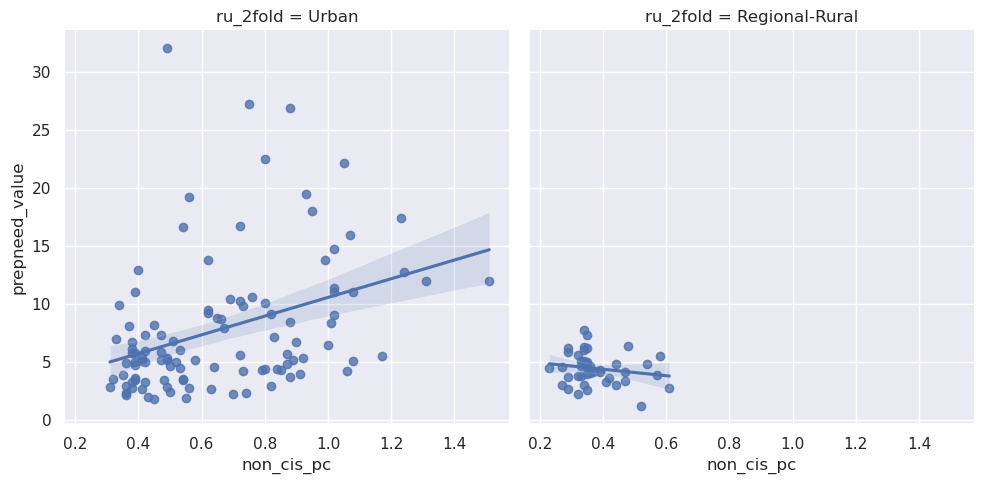

In [81]:
fig = plt.figure(figsize=(12,16))
sns.lmplot(data=full_df, x='non_cis_pc', y='prepneed_value', col=ru_cats)

plt.show()

<Figure size 1200x2000 with 0 Axes>

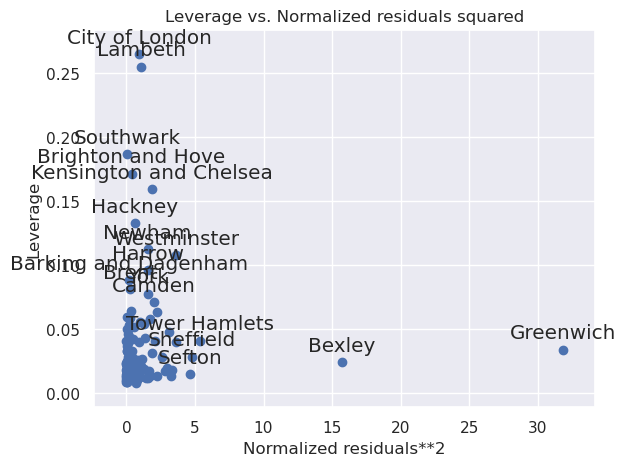

In [43]:
fig = plt.figure(figsize=(12,20))
fig = sm.graphics.plot_leverage_resid2(model2_sigonly)
fig.tight_layout(pad=1.0)

### 3.6 Non-parametric Tests
The Mann-Whitney U test is a nonparametric test of the null hypothesis that the distribution underlying sample x is the same as the distribution underlying sample y. It is often used as a test of difference in location between distributions.  

The Wilcoxon signed-rank test tests the null hypothesis that two related *paired* samples come from the same distribution. In particular, it tests whether the distribution of the differences x - y is symmetric about zero. It is a non-parametric version of the paired T-test.